In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

import os
import xml.etree.ElementTree as ET

In [2]:
image_trainval_root = '/Users/neil/Code/LTNtorch/SII_LTN/data/semanticPascalPart/JPEGImages_trainval'
image_test_root = '/Users/neil/Code/LTNtorch/SII_LTN/data/semanticPascalPart/JPEGImages_test'
annotation_trainval_root = '/Users/neil/Code/LTNtorch/SII_LTN/data/semanticPascalPart/Annotations_trainval'
annotation_test_root = '/Users/neil/Code/LTNtorch/SII_LTN/data/semanticPascalPart/Annotations_test'

def parse_custom_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    objects = []
    
    size = root.find('imagesize')
    width = int(size.find('ncols').text)
    height = int(size.find('nrows').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        
        polygon = obj.find('polygon')
        points = []
        for pt in polygon.findall('pt'):
            x = int(pt.find('x').text)
            y = int(pt.find('y').text)
            points.append([x, y])
        
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        xmin = min(x_coords)
        ymin = min(y_coords)
        xmax = max(x_coords)
        ymax = max(y_coords)
        
        objects.append({
            'label': label,
            'bbox': [xmin, ymin, xmax, ymax],
            'polygon': points
        })
    
    return {
        'width': width,
        'height': height,
        'objects': objects
    }

class PascalPartDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transform=None):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.transform = transform

        self.image_files = [f for f in os.listdir(self.root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        xml_file = os.path.join(self.annotation_dir, self.image_files[idx].replace('.jpg', '.xml'))
        annotations = parse_custom_xml(xml_file)

        # 从 annotations['objects'] 提取每个对象的 bbox 和 label
        boxes = torch.as_tensor([obj['bbox'] for obj in annotations['objects']], dtype=torch.float32)
        labels = torch.as_tensor([1 if obj['label'] == 'Train' else 0 for obj in annotations['objects']], dtype=torch.int64)

        if self.transform:
            img = self.transform(img)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_set = PascalPartDataset(root_dir=image_trainval_root, annotation_dir=annotation_trainval_root, transform=transform)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

test_set = PascalPartDataset(root_dir=image_test_root, annotation_dir=annotation_test_root, transform=transform)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

Training Set Samples:
Batch 1:
Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[  1.,  10., 465., 500.],
        [441.,  59., 465., 226.],
        [  1.,  51., 440., 287.],
        [108., 465., 367., 500.],
        [  3.,  10., 465., 500.]])
Labels: tensor([0, 0, 0, 0, 0])


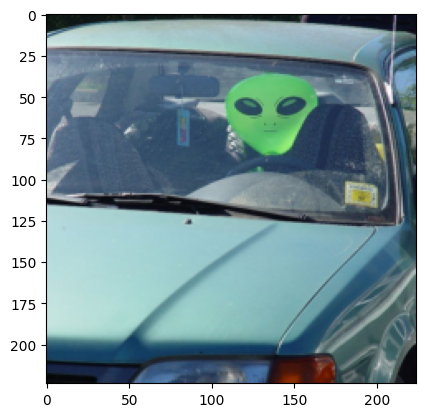

Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[  1., 140., 212., 295.],
        [ 93., 144., 168., 228.],
        [  1., 142., 174., 259.],
        [179., 163., 212., 206.],
        [171., 161., 180., 165.],
        [145., 145., 162., 160.],
        [150., 140., 158., 145.],
        [145., 141., 211., 206.]])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


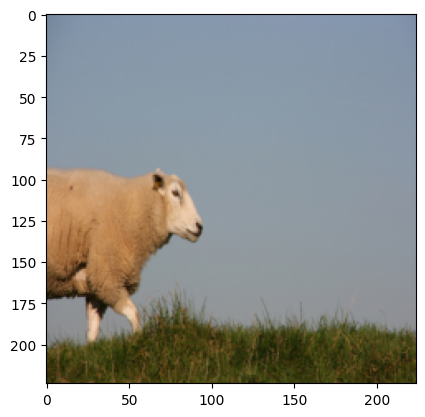

Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[  4., 134., 247., 239.],
        [ 32., 218., 131., 239.],
        [163., 212., 208., 229.],
        [176., 152., 207., 216.],
        [  4., 134., 207., 234.],
        [187., 143., 247., 218.],
        [211., 187., 216., 190.],
        [238., 186., 242., 188.],
        [201., 142., 218., 163.],
        [233., 145., 246., 161.]])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


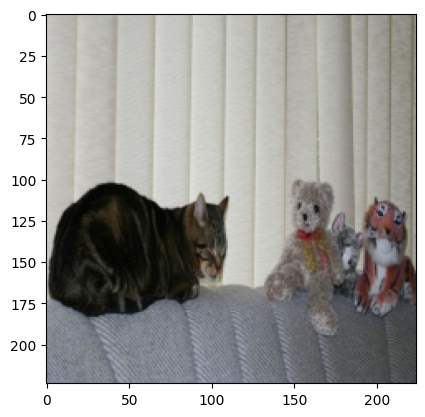

Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[ 47., 196.,  76., 262.],
        [ 49., 258.,  56., 262.],
        [ 47., 223.,  59., 260.],
        [ 67., 258.,  76., 262.],
        [ 57., 223.,  73., 260.],
        [ 68., 231.,  73., 236.],
        [ 63., 209.,  70., 232.],
        [ 52., 206.,  66., 227.],
        [ 55., 196.,  63., 201.],
        [ 55., 196.,  63., 207.],
        [ 87., 157., 415., 271.],
        [380., 187., 398., 212.],
        [353., 186., 374., 212.],
        [323., 185., 346., 220.],
        [290., 187., 315., 220.],
        [255., 185., 282., 221.],
        [214., 183., 246., 225.],
        [183., 184., 208., 225.],
        [136., 182., 177., 223.],
        [103., 180., 136., 221.],
        [366., 231., 379., 259.],
        [213., 235., 236., 271.],
        [155., 246., 167., 250.],
        [100., 241., 110., 248.],
        [158., 240., 164., 243.],
        [101., 235., 108., 239.],
        [ 87., 185.,  95., 204.],
        [185., 198., 194., 211.],
  

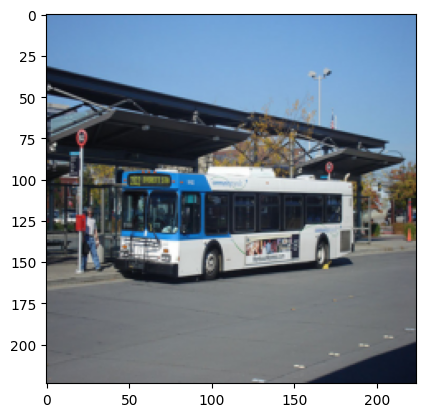

In [4]:
import matplotlib.pyplot as plt

# 打印训练集中的样本信息
print("Training Set Samples:")
for i, (images, targets) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    
    # 打印图像和目标（边界框和标签）
    for img, target in zip(images, targets):
        print(f"Image shape: {img.shape}")  # 图像的形状
        print(f"Boxes: {target['boxes']}")  # 边界框
        print(f"Labels: {target['labels']}")  # 标签
        
        # 显示图像
        img_np = img.permute(1, 2, 0).numpy()  # 从 (C, H, W) 转为 (H, W, C)
        plt.imshow(img_np)
        plt.show()
    
    # 如果只想打印第一个 batch，可以加个 break
    if i == 0:
        break

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 31
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

/Users/neil/miniconda3/envs/LTN_Torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/neil/miniconda3/envs/LTN_Torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/neil/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.1MB/s]


In [10]:
# 设置优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# 开始训练
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        # 前向传播
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # 反向传播
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {losses.item()}')

AssertionError: All bounding boxes should have positive height and width. Found invalid box [1432.142822265625, 760.7142944335938, 1432.142822265625, 760.7142944335938] for target at index 1.